In [1]:
!pip install --upgrade scikit-learn==1.2.2 imbalanced-learn==0.10.1 xgboost pandas numpy matplotlib seaborn joblib


     ---------------------------------------- 0.0/7.3 MB ? eta -:--:--
     ---------- ----------------------------- 1.8/7.3 MB 10.0 MB/s eta 0:00:01
     --------------------- ------------------ 3.9/7.3 MB 11.2 MB/s eta 0:00:01
     ---------------------------------- ----- 6.3/7.3 MB 11.0 MB/s eta 0:00:01
     ---------------------------------------- 7.3/7.3 MB 10.7 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'error'


  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [33 lines of output]
      Partial import of sklearn during the build process.
      Traceback (most recent call last):
        File "C:\Users\guera\Documentos\agente-financeiro\venv\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 389, in <module>
          main()
        File "C:\Users\guera\Documentos\agente-financeiro\venv\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 373, in main
          json_out["return_val"] = hook(**hook_input["kwargs"])
                                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "C:\Users\guera\Documentos\agente-financeiro\venv\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 175, in prepare_metadata_for_build_wheel
          return hook(metadata_directory, config_settings)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import joblib
import sys

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    f1_score,
    ConfusionMatrixDisplay,
)

from imblearn.pipeline import Pipeline  # Pipeline do imblearn para usar SMOTE
from imblearn.over_sampling import SMOTE  # SMOTE para balanceamento
import xgboost as xgb

In [3]:
logging.basicConfig(
    level=logging.INFO, format="[%(asctime)s] %(levelname)s - %(message)s"
)
logger = logging.getLogger(__name__)
logger.info(f"Python: {sys.version}")
logger.info(f"scikit-learn: {sys.modules['sklearn'].__version__}")
logger.info(f"imbalanced-learn: {sys.modules['imblearn'].__version__}")
logger.info(f"xgboost: {xgb.__version__}")

[2025-06-26 14:16:13,846] INFO - Python: 3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 13:17:27) [MSC v.1929 64 bit (AMD64)]
[2025-06-26 14:16:13,847] INFO - scikit-learn: 1.6.1
[2025-06-26 14:16:13,849] INFO - imbalanced-learn: 0.13.0
[2025-06-26 14:16:13,850] INFO - xgboost: 3.0.2


In [15]:
DATA_PATH = "../data/processed/training_data.csv"
df = pd.read_csv(DATA_PATH, nrows=10_000)
logger.info(f"Dataset carregado com {df.shape[0]} linhas e {df.shape[1]} colunas.")

[2025-06-26 14:38:37,038] INFO - Dataset carregado com 10000 linhas e 20 colunas.


In [5]:
for col in ["data_emissao", "data_vencimento"]:
    df[col] = pd.to_datetime(df[col], errors="coerce")
df["prazo_dias"] = (df["data_vencimento"] - df["data_emissao"]).dt.days

In [6]:
def extract_text_features(df):
    df["descricao"] = df["descricao"].astype(str).fillna("")
    df["observacao"] = df["observacao"].astype(str).fillna("")
    df["tem_nota_fiscal"] = (
        df["descricao"].str.contains("nota fiscal", case=False, na=False).astype(int)
    )
    df["tem_imposto"] = (
        df["descricao"].str.contains("imposto", case=False, na=False).astype(int)
    )
    df["tem_boleto"] = (
        df["descricao"].str.contains("boleto", case=False, na=False).astype(int)
    )
    df["tem_recurso_juridico"] = (
        df["observacao"].str.contains("recurso", case=False, na=False).astype(int)
    )
    return df

df = extract_text_features(df)

In [7]:
TARGET_COL = "classificacao"
drop_cols = [
    "id",
    "nome_emissor",
    "cnpj_emissor",
    "cpf_responsavel",
    "numero_documento",
    "raiz_cnpj",
    "filial_cnpj",
    "dv_cnpj",
    "descricao",
    "observacao",
    "data_emissao",
    "data_vencimento",
    "categoria",
    "status",
    "tipo_documento",
]


In [8]:
y_counts = df[TARGET_COL].value_counts()
valid_classes = y_counts[y_counts >= 5].index
df = df[df[TARGET_COL].isin(valid_classes)]

In [9]:
X = df.drop(columns=[col for col in drop_cols if col in df.columns] + [TARGET_COL])
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df[TARGET_COL])

In [10]:
numerical_cols = [
    "valor_total",
    "numero_paginas",
    "confianca_esperada",
    "prazo_dias",
    "tem_nota_fiscal",
    "tem_imposto",
    "tem_boleto",
    "tem_recurso_juridico",
]
for col in numerical_cols:
    X[col] = pd.to_numeric(X[col], errors="coerce")

X[numerical_cols] = X[numerical_cols].fillna(X[numerical_cols].median())
X[numerical_cols] = X[numerical_cols].fillna(0)
assert not X[numerical_cols].isnull().any().any(), "Ainda há NaNs nas colunas numéricas!"

In [11]:
preprocessor = ColumnTransformer([("num", StandardScaler(), numerical_cols)])

pipeline = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=42)),  # SMOTE aplicado somente no treino dentro da pipeline
        (
            "classifier",
            xgb.XGBClassifier(
                use_label_encoder=False,
                eval_metric="mlogloss",
                random_state=42,
                n_jobs=-1,
            ),
        ),
    ]
)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [17]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    "classifier__n_estimators": [100, 200],
    "classifier__max_depth": [4, 6, 10],
    "classifier__learning_rate": [0.05, 0.1],
    "classifier__subsample": [0.8, 1],
    "classifier__colsample_bytree": [0.8, 1],
}

random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_grid,
    n_iter=10,  # número de combinações aleatórias a testar
    scoring="f1_macro",
    cv=3,  # reduzido de 5 para 3 para acelerar
    verbose=2,
    n_jobs=-1,
    random_state=42,
)

In [19]:
logger.info("Iniciando RandomizedSearchCV com XGBoost e SMOTE...")
random_search.fit(X_train, y_train)
logger.info(f"Melhores parâmetros: {random_search.best_params_}")
logger.info(f"Melhor F1 Macro (validação): {random_search.best_score_:.4f}")


[2025-06-26 14:42:00,985] INFO - Iniciando RandomizedSearchCV com XGBoost e SMOTE...


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\guera\Documentos\agente-financeiro\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:45:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[2025-06-26 14:46:00,705] INFO - Melhores parâmetros: {'classifier__subsample': 1, 'classifier__n_estimators': 200, 'classifier__max_depth': 4, 'classifier__learning_rate': 0.05, 'classifier__colsample_bytree': 1}
[2025-06-26 14:46:00,706] INFO - Melhor F1 Macro (validação): 0.8578


In [21]:
y_pred = random_search.predict(X_test)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
print(f"Acurácia: {accuracy_score(y_test, y_pred):.4f}")
print(f"F1-score macro: {f1_score(y_test, y_pred, average='macro'):.4f}")

              precision    recall  f1-score   support

    contábil       1.00      0.91      0.95     26147
  financeiro       0.93      0.70      0.79     39474
      fiscal       0.47      0.97      0.63     13156
    jurídico       1.00      1.00      1.00     13101
  tributário       0.99      0.85      0.92     13122

    accuracy                           0.84    105000
   macro avg       0.88      0.88      0.86    105000
weighted avg       0.90      0.84      0.85    105000

Acurácia: 0.8404
F1-score macro: 0.8586


<Figure size 800x600 with 0 Axes>

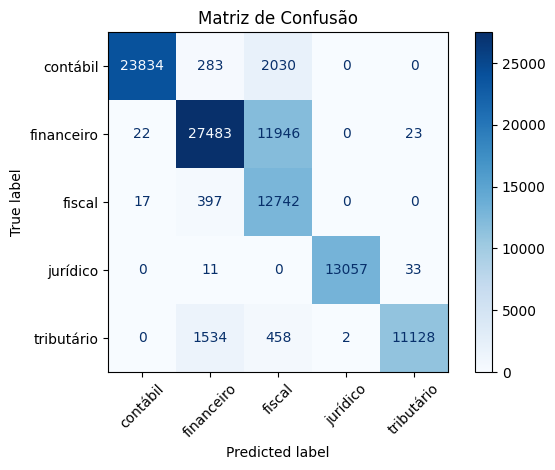

In [23]:
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay.from_estimator(
    random_search, X_test, y_test, display_labels=label_encoder.classes_, cmap="Blues"
)
plt.title("Matriz de Confusão")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



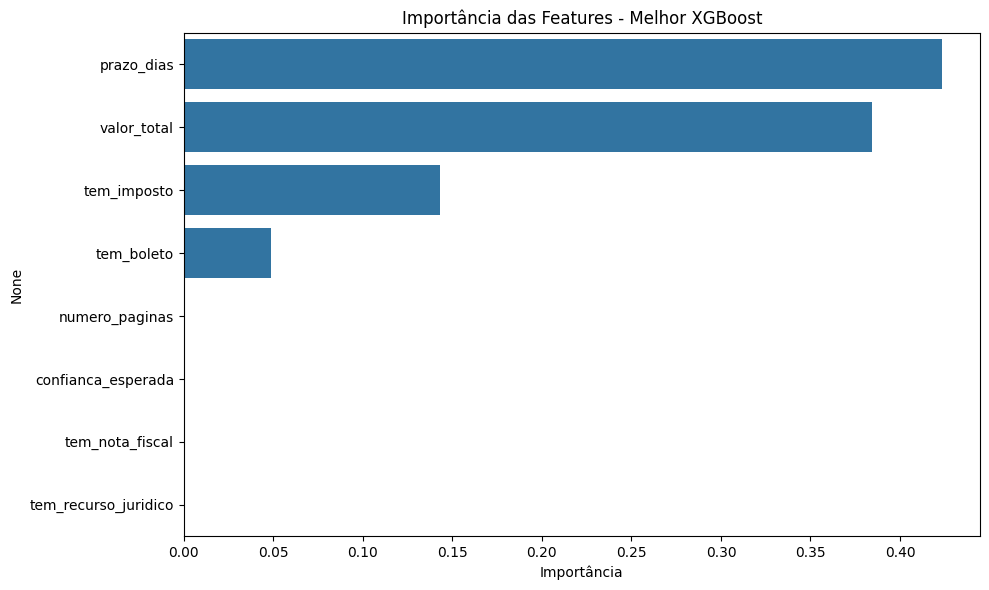

In [25]:
best_xgb = random_search.best_estimator_.named_steps["classifier"]
importances = best_xgb.feature_importances_
feature_names = numerical_cols
importances_df = pd.Series(importances, index=feature_names).sort_values(
    ascending=False
)
plt.figure(figsize=(10, 6))
sns.barplot(x=importances_df.values, y=importances_df.index)
plt.title("Importância das Features - Melhor XGBoost")
plt.xlabel("Importância")
plt.tight_layout()
plt.show()

In [26]:
MODEL_PATH = "../models/xgb_pipeline_best.pkl"
joblib.dump(
    {"model": random_search.best_estimator_, "label_encoder": label_encoder}, MODEL_PATH
)
logger.info(f"Modelo + encoder salvos em {MODEL_PATH}")

[2025-06-26 14:51:27,489] INFO - Modelo + encoder salvos em ../models/xgb_pipeline_best.pkl
